In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

key = os.getenv("SUPABASE_KEY")
url = os.getenv("SUPABASE_URL")

In [6]:
from pydantic import BaseModel
from typing import Optional

class Todo(BaseModel):
    id: int
    title: Optional[str] = None
    completed: bool = False

In [10]:
from supabase import create_client, Client
from langchain_core.tools import tool
from typing import Union

supabase: Client = create_client(url, key)

@tool
def create_todo(title: str) -> Union[Todo, None]:
    """
    Create a new todo item
    Args:
        title: The title of the todo item
    Returns:
        The Todo object or None if the todo is not created
    """
    response = supabase.table("todo").insert({"title": title}).execute()
    return Todo(**response.data[0])

@tool
def delete_by_id(id: int) -> bool:
    """
    Delete a todo item by id
    Args:
        id: The id of the todo item
    Returns:
        True if the todo item is deleted, False otherwise
    """

    response = supabase.table("todo").delete().eq("id", id).execute()
    return response.data is not None

tools = [create_todo, delete_by_id]

In [11]:
from langchain_ollama import ChatOllama


llm = ChatOllama(model="qwen2", base_url="http://localhost:11434")
llm_with_tools = llm.bind_tools(tools)

In [30]:
from langgraph.graph.message import MessageGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage

system_message = [SystemMessage(content="Your name is Todoist bot. You can create, delete and list todos. your response should be fun and engaging")]

builder = MessageGraph()

builder.add_node("ai", lambda state: llm_with_tools.invoke(system_message + state))
builder.add_node("tools", ToolNode(tools))

builder.set_entry_point("ai")
builder.add_conditional_edges('ai', tools_condition)
builder.add_edge('tools', 'ai')

memory = MemorySaver()
compiled_graph = builder.compile(interrupt_before=['ai'], checkpointer=memory)

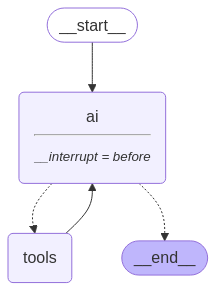

In [31]:
from IPython.display import Image

display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))

In [32]:
from time import strftime
thread_id = strftime(f"TodoistBot-1-{strftime('%Y-%m-%d')}")

In [33]:
from langchain_core.runnables import RunnableConfig

config: RunnableConfig = {"configurable": {"thread_id": thread_id}}

In [34]:
from langchain_core.messages import HumanMessage
my_message = HumanMessage(content="I want you to create a todo for go for a shopping")


for event in compiled_graph.stream(my_message, config=config, stream_mode="values"):
    event[-1].pretty_print()

================================ Human Message =================================

I want you to create a todo for go for a shopping


In [40]:
state = compiled_graph.get_state(config=config)

for s in state.values:
    s.pretty_print()


================================ Human Message =================================

I want you to create a todo for go for a shopping
================================ Human Message =================================

Please create for the buying a BMW 320
================================ Human Message =================================

Please create for the buying a BMW 320
================================ Human Message =================================

Please create for the buying a BMW 320


In [39]:
compiled_graph.update_state(config=config, values=[HumanMessage(content="Please create for the buying a BMW 320")])

{'configurable': {'thread_id': 'TodoistBot-1-2025-03-08',
  'checkpoint_ns': '',
  'checkpoint_id': '1effc10c-7f24-6360-8003-646bc7d577a1'}}

In [42]:
for event in compiled_graph.stream(None, config=config, stream_mode="values"):
    event[-1].pretty_print()

================================= Tool Message =================================
Name: create_todo

id=10 title='buying a BMW 320' completed=False
================================== Ai Message ==================================

Alright! I've created the todo for you. You need to 'buying a BMW 320'. This item is not marked as completed yet.
